In [19]:
from pathlib import Path

import pandas as pd
from google_play_scraper import app
from tqdm import tqdm
import matplotlib.pyplot as plt
from scapy.all import rdpcap

tqdm.pandas()

In [20]:
def get_number_of_flows_per_pcap(pcap_path):
    """
    Given a path to a PCAP file, this function returns the number of unique network flows
    in the file. A flow is defined by a 5-tuple: (source IP, destination IP, source port, 
    destination port, protocol).
    
    Args:
    - pcap_path: Path to the PCAP file.
    
    Returns:
    - int: Number of unique network flows in the PCAP file.
    """
    packets = rdpcap(str(pcap_path))
    
    flows = set()
    
    for packet in packets:
        if 'IP' in packet and ('TCP' in packet or 'UDP' in packet):
            # Extract 5-tuple (source IP, destination IP, source port, destination port, protocol)
            src_ip = packet['IP'].src
            dst_ip = packet['IP'].dst
            if packet.haslayer('TCP'):
                protocol = 'TCP'
                src_port = packet['TCP'].sport
                dst_port = packet['TCP'].dport
            elif packet.haslayer('UDP'):
                protocol = 'UDP'
                src_port = packet['UDP'].sport
                dst_port = packet['UDP'].dport

            flow = (src_ip, dst_ip, src_port, dst_port, protocol)
            flows.add(flow)
    
    return len(flows)


def get_app_genre(app_id, country='us'):
    country = country.lower()
    if country == 'india':
        country = 'in'
    elif country == 'us' or country == 'usa':
        country = 'us'
    elif country == 'china':
        country = 'cn'
    try:
        return app(app_id, country=country)['genre']
    except Exception as e:
        return str(e)

In [ ]:
for f, l in train_loader

/tmp/ipykernel_3883101/263685250.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  grouped = android_df[df.os == 'Android'].groupby(['genre', 'country']).country.count().unstack(fill_value=0)


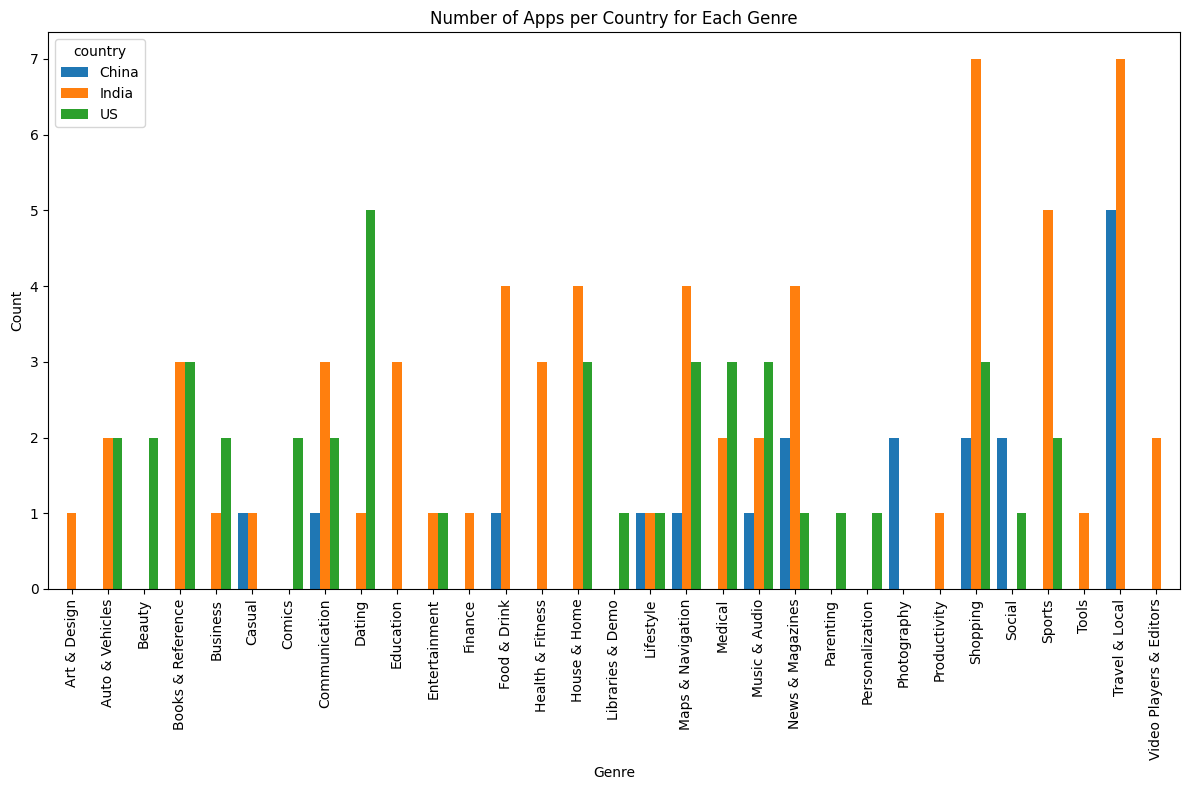

In [8]:
android_df = df[(df.os == 'Android') & (df.genre != 'App not found(404).')]
grouped = android_df[df.os == 'Android'].groupby(['genre', 'country']).country.count().unstack(fill_value=0)

# Create the bar plot
grouped.plot(kind='bar', stacked=False, figsize=(12, 8), width=.8)

# Add labels and title
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Number of Apps per Country for Each Genre')
plt.xticks(rotation=90)

# Display the plot
plt.tight_layout()
plt.savefig('tmp.png')


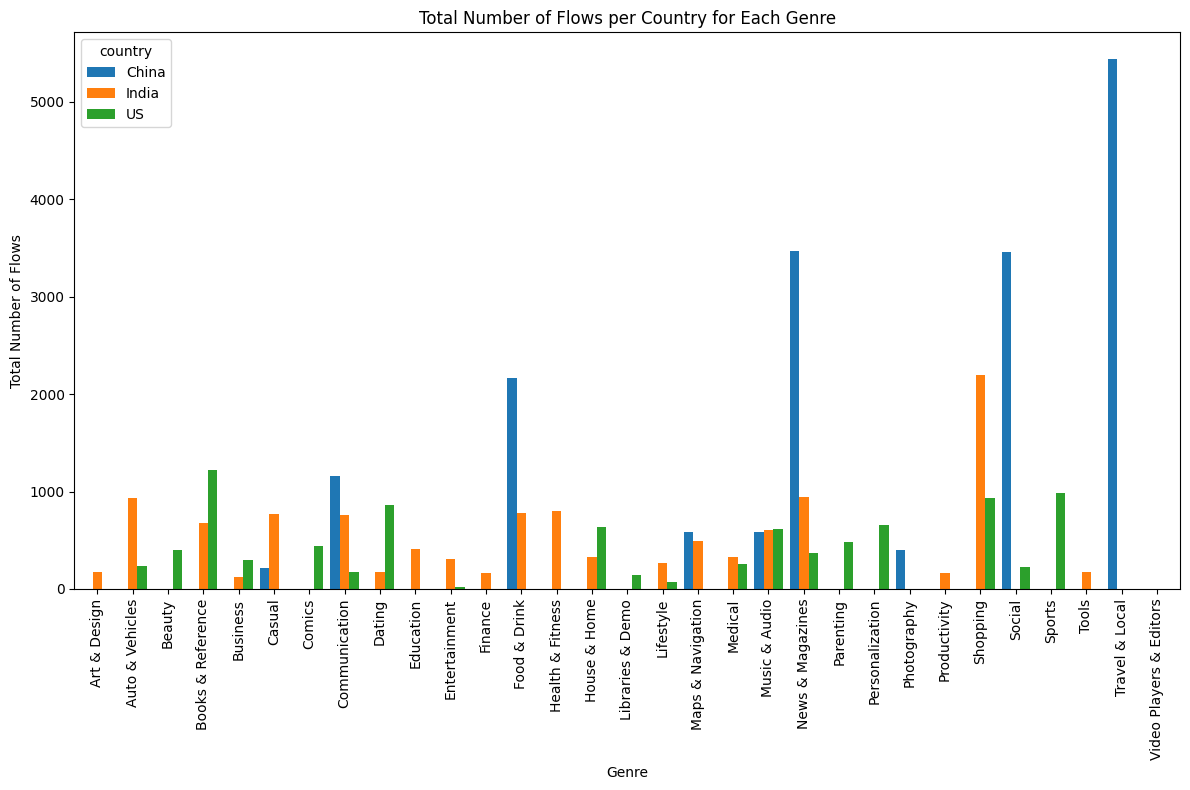

In [10]:
# Group by genre and country and sum the number of flows
grouped_flows = android_df.groupby(['genre', 'country']).n_flows.sum().unstack(fill_value=0)

# Create the bar plot based on total number of flows
grouped_flows.plot(kind='bar', stacked=False, figsize=(12, 8), width=.8)

# Add labels and title
plt.xlabel('Genre')
plt.ylabel('Total Number of Flows')
plt.title('Total Number of Flows per Country for Each Genre')
plt.xticks(rotation=90)

# Display the plot
plt.tight_layout()
plt.show()

In [22]:
cross_platform_shared_genres = ['Books & Reference', 'Auto & Vehicles', 'Business', 'Communication', 'Dating', 'House & Home', 'Lifestyle', 'Medical', 'Music & Audio', 'News & Magazines', 'Shopping']
chosen_countries = ['India', 'US']

In [24]:
genre_df = df[df.genre.isin(cross_platform_shared_genres) & df.country.isin(chosen_countries)]

In [27]:
genre_df.groupby(['genre', 'country']).n_flows.sum()

genre              country
Auto & Vehicles    India       936
                   US          234
Books & Reference  India       678
                   US         1220
Business           India       118
                   US          301
Communication      India       764
                   US          172
Dating             India       178
                   US          862
House & Home       India       327
                   US          638
Lifestyle          India       264
                   US           75
Medical            India       323
                   US          258
Music & Audio      India       602
                   US          614
News & Magazines   India       946
                   US          367
Shopping           India      2191
                   US          935
Name: n_flows, dtype: int64

In [1]:
from pathlib import Path

import pandas as pd
from google_play_scraper import app
from tqdm import tqdm
import matplotlib.pyplot as plt
from scapy.all import rdpcap

from dataloader import create_dataloader

tqdm.pandas()

In [2]:
data_path = Path('data/cross_platform')
df = pd.read_csv(data_path / 'cross_platform.csv', index_col=0)


In [3]:
cross_platform_by_genre = ['Books & Reference', 'Auto & Vehicles', 'Business', 'Communication', 
                           'Dating', 'House & Home', 'Lifestyle', 'Medical', 'Music & Audio', 
                           'News & Magazines', 'Shopping']

In [4]:
# Example usage
csv_path = 'data/cross_platform/cross_platform.csv'  # Update with actual CSV path
india_df = df[(df.country == 'India') & df.genre.isin(cross_platform_by_genre)] 
# Create a dataloader
pcap_paths = india_df.paths
labels = india_df.genre

train_loader, test_loader = create_dataloader(pcap_paths, labels, batch_size=64, shuffle=True, split_ratio=0.8)

0it [00:00, ?it/s]

1it [00:01,  1.91s/it]
1it [00:01,  1.85s/it]


In [5]:

# Use train_loader for training and test_loader for validation
for batch in train_loader:
    flowpics, labels = batch
    print(flowpics.shape, labels.shape)
    break

for batch in test_loader:
    flowpics, labels = batch
    print(flowpics.shape, labels.shape)
    # break




torch.Size([64, 1500, 1500]) torch.Size([64])
torch.Size([61, 1500, 1500]) torch.Size([61])


In [6]:
labels

tensor([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10.])